# 可选实验室——简单神经网络

在本实验中，我们将使用Tensorflow构建一个小型神经网络。

<center>
    <img src="../../images/C2_W1_CoffeeRoasting.png" width="400" />
<center/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('./deeplearning.mplstyle')
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from lab_coffee_utils import load_coffee_data, plt_roast, plt_layer, plt_network, plt_output_unit
import logging

logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config, )

## 数据集

In [2]:
X, Y = load_coffee_data()
print(X.shape, Y.shape)

(200, 2) (200, 1)


让我们绘制下面的咖啡烘焙数据。这两个功能是以摄氏度为单位的温度和以分钟为单位的持续时间。[在家烘焙咖啡](https://www.merchantsofgreencoffee.com/how-to-roast-green-coffee-in-your-oven/)建议时间最好保持在12到15分钟之间，温度以 温度在175至260摄氏度之间。当然，随着温度升高，持续时间应该缩短。

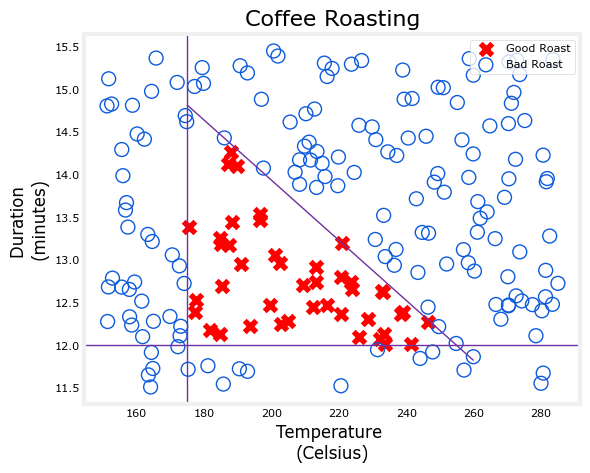

In [3]:
plt_roast(X, Y)

### 标准化数据

如果数据标准化，则将权重与数据拟合（反向传播，将在下周的讲座中介绍）将进行得更快。这与您在课程1中使用的过程相同，其中数据中的每个特征都被标准化为具有相似的范围。

下面的过程使用Keras[标准化层](https://keras.io/api/layers/preprocessing_layers/numerical/normalization/)。它有以下步骤：

- 创建一个“标准化层”。请注意，正如此处所应用的，这不是模型中的层。
- “调整”数据。这将学习数据集的均值和方差并在内部保存这些值。
- 标准化数据。

将标准化应用于利用学习模型的任何未来数据非常重要。

In [4]:
print(f"Temperature Max, Min pre normalization: {np.max(X[:, 0]):0.2f}, {np.min(X[:, 0]):0.2f}")
print(f"Duration    Max, Min pre normalization: {np.max(X[:, 1]):0.2f}, {np.min(X[:, 1]):0.2f}")
norm_l = tf.keras.layers.Normalization(axis=-1)
norm_l.adapt(X)
Xn = norm_l(X)
print(f"Temperature Max, Min post normalization: {np.max(Xn[:, 0]):0.2f}, {np.min(Xn[:, 0]):0.2f}")
print(f"Duration    Max, Min post normalization: {np.max(Xn[:, 1]):0.2f}, {np.min(Xn[:, 1]):0.2f}")

Temperature Max, Min pre normalization: 284.99, 151.32
Duration    Max, Min pre normalization: 15.45, 11.51
Temperature Max, Min post normalization: 1.66, -1.69
Duration    Max, Min post normalization: 1.79, -1.70


平铺/复制我们的数据以增加训练集大小并减少训练时期的数量。

In [5]:
Xt = np.tile(Xn, (1000, 1))
Yt = np.tile(Y, (1000, 1))
print(Xt.shape, Yt.shape)

(200000, 2) (200000, 1)


## TensorFlow模型

### 模型

<center>
    <img src="../../images/C2_W1_RoastingNetwork.PNG" width="200" />
<center/>  

让我们构建讲座中描述的“咖啡烘焙网络”。有两层具有sigmoid激活，如下所示：

In [6]:
tf.random.set_seed(1234)
model = Sequential([tf.keras.Input(shape=(2,)), Dense(3, activation='sigmoid', name='layer1'),
                    Dense(1, activation='sigmoid', name='layer2')])

>**注1：**`tf.keras.Input(shape=(2,)),`指定输入的预期形状。这允许Tensorflow此时调整权重和偏差参数的大小。这在探索Tensorflow模型时非常有用。在实践中可以省略该语句，当在`model.fit`语句中指定输入数据时，Tensorflow将调整网络参数的大小。

>**注2：** 在最后一层中包含sigmoid激活不被认为是最佳实践。相反，它会被计入损失中，从而提高数值稳定性。这将在稍后的实验中更详细地描述。

`model.summary()`提供了网络的描述：

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 3)                 9         
                                                                 
 layer2 (Dense)              (None, 1)                 4         
                                                                 
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


摘要中显示的参数计数对应于权重和偏差数组中的元素数量，如下所示。

In [8]:
L1_num_params = 2 * 3 + 3
L2_num_params = 3 * 1 + 1
print("L1 params = ", L1_num_params, ", L2 params = ", L2_num_params)

L1 params =  9 , L2 params =  4


让我们检查一下Tensorflow实例化的权重和偏差。权重$W$的大小应为`(输入中的特征数量,层中的单元数量`，而偏差$b$的大小应与层中的单元数量匹配：

- 在具有3个单元的第一层中，我们期望W的大小为`(2,3)`，$b$应该有3个元素。
- 在具有1个单元的第二层中，我们期望W的大小为`(3,1)`并且$b$应该有1个元素。

In [9]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1)
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

W1(2, 3):
 [[-0.97  0.08  0.89]
 [ 0.73  0.2   0.22]] 
b1(3,): [0. 0. 0.]
W2(3, 1):
 [[-0.31]
 [-0.4 ]
 [ 1.19]] 
b2(1,): [0.]


以下说法将在Week2中详细介绍。目前：

- `model.compile`语句定义了损失函数并指定了编译优化。
- `model.fit`语句运行梯度下降并将权重拟合到数据。

In [10]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), )
model.fit(Xt, Yt, epochs=10, )

Epoch 1/10
6250/6250 [==============================] - 9s 1ms/step - loss: 0.1865
Epoch 2/10
6250/6250 [==============================] - 7s 1ms/step - loss: 0.1194
Epoch 3/10
6250/6250 [==============================] - 7s 1ms/step - loss: 0.0468
Epoch 4/10
6250/6250 [==============================] - 7s 1ms/step - loss: 0.0177
Epoch 5/10
6250/6250 [==============================] - 7s 1ms/step - loss: 0.0117
Epoch 6/10
6250/6250 [==============================] - 7s 1ms/step - loss: 0.0084
Epoch 7/10
6250/6250 [==============================] - 7s 1ms/step - loss: 0.0061
Epoch 8/10
6250/6250 [==============================] - 7s 1ms/step - loss: 0.0045
Epoch 9/10
6250/6250 [==============================] - 7s 1ms/step - loss: 0.0033
Epoch 10/10
6250/6250 [==============================] - 7s 1ms/step - loss: 0.0025


#### 更新权重

拟合后，权重已更新：

In [11]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print("W1:\n", W1, "\nb1:", b1)
print("W2:\n", W2, "\nb2:", b2)

W1:
 [[14.46 -0.02 12.85]
 [12.01 -8.92  0.33]] 
b1: [  1.77 -11.2   13.39]
W2:
 [[-43.2 ]
 [-45.57]
 [ 38.59]] 
b2: [-12.43]


接下来，我们将加载之前训练运行中保存的一些权重。这样一来，随着时间的推移，该笔记本仍能适应Tensorflow的变化。不同的训练运行可能会产生有些不同的结果，下面的讨论适用于特定的解决方案。请随意重新运行笔记本并注释掉此单元格以查看差异。

In [12]:
W1 = np.array([
    [-8.94, 0.29, 12.89],
    [-0.17, -7.34, 10.79]])
b1 = np.array([-9.87, -9.28, 1.01])
W2 = np.array([
    [-31.38],
    [-27.86],
    [-32.79]])
b2 = np.array([15.54])
model.get_layer("layer1").set_weights([W1, b1])
model.get_layer("layer2").set_weights([W2, b2])

 ### 预测
 
<img align="left" src="../../images/C2_W1_RoastingDecision.PNG" style=" width:380px; padding: 10px 20px; " >

一旦你有了经过训练的模型，你就可以用它来进行预测。回想一下，我们模型的输出是概率。在这种情况下，烘焙良好的概率。为了做出决定，必须将概率应用于阈值。在本例中，我们将使用0.5

让我们从创建输入数据开始。该模型需要一个或多个示例，其中示例位于矩阵的行中。在本例中，我们有两个特征，因此矩阵将为`(m,2)`，其中`m`是示例的数量。

回想一下，我们已经标准化了输入特征，因此我们也必须标准化我们的测试数据。

要进行预测，您可以应用`predict`方法。

In [13]:
X_test = np.array([[200, 13.9], [200, 17]])
X_testn = norm_l(X_test)
predictions = model.predict(X_testn)
print("predictions = \n", predictions)

1/1 [==============================] - 0s 50ms/step
predictions = 
 [[9.62e-01]
 [3.03e-08]]


#### 纪元和批次

在上面的`compile`语句中，`epochs`的数量设置为10。这指定整个数据集在训练期间应应用10次。在训练期间，您会看到描述训练进度的输出，如下所示：

```
Epoch 1/10
6250/6250 [==============================] - 6s 910us/step - loss: 0.1782
```

第一行`Epoch 1/10`描述了模型当前运行的纪元。为了提高效率，训练数据集被分成“批次”。Tensorflow中批次的默认大小为32。我们的扩展数据集中有200000个示例或6250个批次。第二行`6250/6250 [====`上的符号描述了哪个批次已被执行。

为了将概率转换为决策，我们应用一个阈值：

In [14]:
yhat = np.zeros_like(predictions)
for i in range(len(predictions)):
    if predictions[i] >= 0.5:
        yhat[i] = 1
    else:
        yhat[i] = 0
print(f"decisions = \n{yhat}")

decisions = 
[[1.]
 [0.]]


这可以更简洁地完成：

In [15]:
yhat = (predictions >= 0.5).astype(int)
print(f"decisions = \n{yhat}")

decisions = 
[[1]
 [0]]


## 层函数

让我们检查一下这些单元的功能，以确定它们在咖啡烘焙决策中的作用。我们将针对所有输入值`(持续时间,温度)`绘制每个节点的输出。每个单元都是一个逻辑函数，其输出范围可以从零到一。图中的阴影表示输出值。

> 注意：在实验室中，我们通常从0开始编号，而讲座可能从1开始。

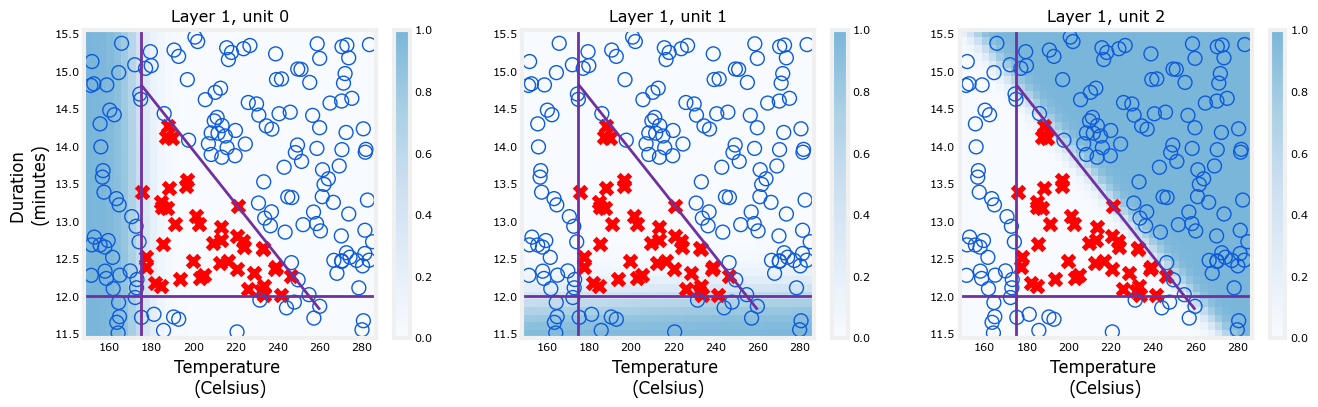

In [16]:
plt_layer(X, Y.reshape(-1, ), W1, b1, norm_l)

阴影显示每个单元负责不同的“烘焙不良”区域。当温度过低时，单元0的值较大。当持续时间太短时，单元1具有较大的值，而对于时间/温度的不良组合，单元2具有较大的值。值得注意的是，网络通过梯度下降的过程自行学习这些函数。它们与人们可能选择做出相同决定的功能非常相似。

最后一层的函数图有点难以可视化。它的输入是第一层的输出。我们知道第一层使用sigmoid，因此它们的输出范围在0到1之间。我们可以创建一个3D图来计算三个输入的所有可能组合的输出。如下所示。上面，高产出值对应于“糟糕的烘焙”区域。下面，最大输出位于三个输入是与“良好烘焙”区域相对应的小值的区域。

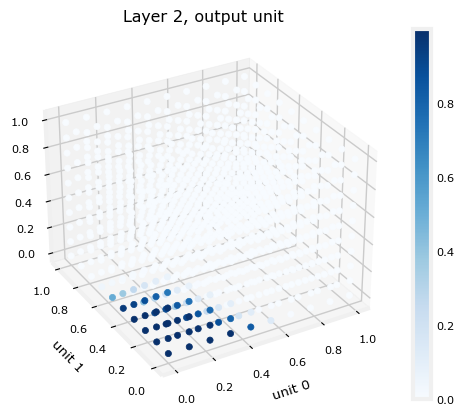

In [17]:
plt_output_unit(W2, b2)

最终图表显示了整个网络的运行情况。

左图是由蓝色阴影表示的最后一层的原始输出。它覆盖在由X和O表示的训练数据上。

右图是经过决策阈值后网络的输出。这里的X和O对应于网络做出的决策。

以下内容需要一些时间才能运行

7/7 [==============================] - 0s 1ms/step


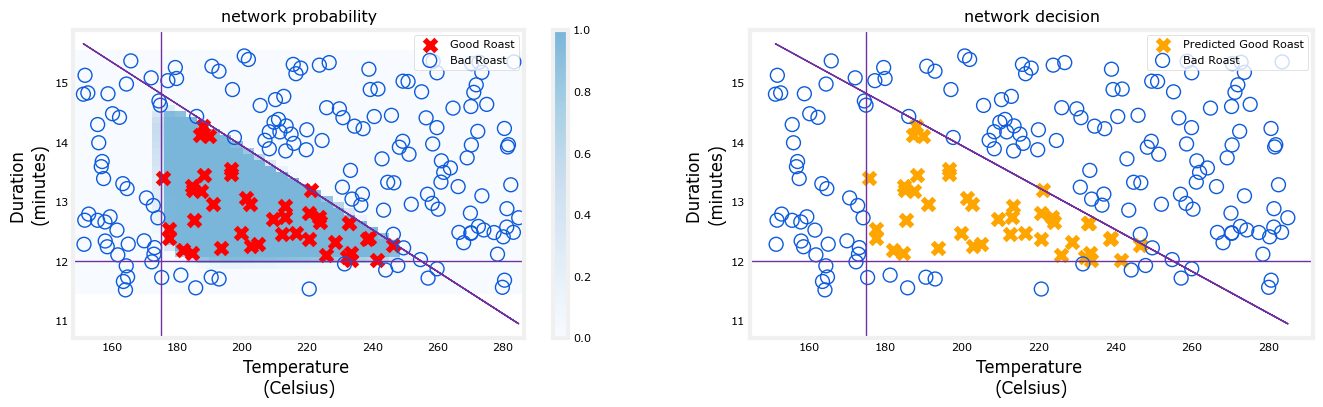

In [18]:
netf = lambda x: model.predict(norm_l(x))
plt_network(X, Y, netf)

## 恭喜！

您已经在Tensorflow中构建了一个小型神经网络。

该网络展示了神经网络通过将决策划分为多个单元来处理复杂决策的能力。